<a href="https://colab.research.google.com/github/shivani250496/Cat-vs-Dog-project/blob/main/cat%20vs%20dog%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from PIL import Image



In [4]:
# Define Constants

In [5]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
# Verify the directory path
train_dir = "/content/drive/MyDrive/Deep Learning Projects/cat dog classifier/test/train"
print(f"Checking directory: {train_dir}")

# Check for images
import os
num_images = len(os.listdir(train_dir))
print(f"Number of images found: {num_images}")

# Check image formats
allowed_formats = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
for filename in os.listdir(train_dir):
    _, extension = os.path.splitext(filename)

Checking directory: /content/drive/MyDrive/Deep Learning Projects/cat dog classifier/test/train
Number of images found: 402


In [7]:
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [8]:
df.head()

,filename,category
0,cat.5.jpg,0
1,cat.0.jpg,0
2,cat.12.jpg,0
3,cat.4.jpg,0
4,cat.13.jpg,0


In [9]:
df.tail()

,filename,category
397,dog.197.jpg,1
398,dog.196.jpg,1
399,dog.198.jpg,1
400,dog.199.jpg,1
401,dog.200.jpg,1


<Axes: xlabel='category'>

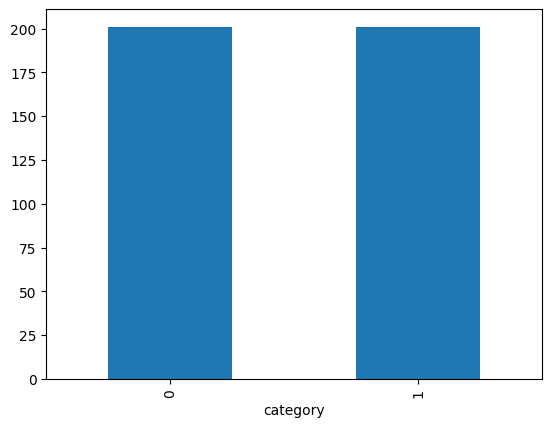

In [10]:
df['category'].value_counts().plot.bar()

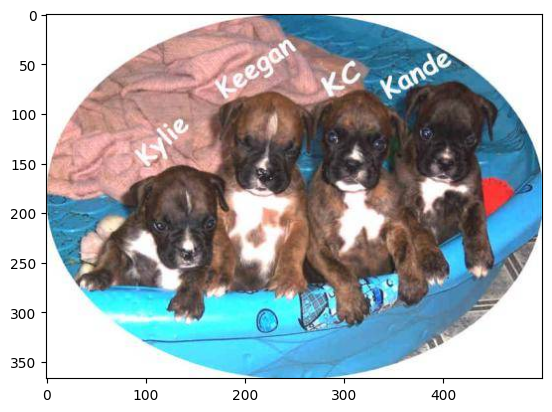

In [12]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Deep Learning Projects/cat dog classifier/test/train/"+sample)
plt.imshow(image)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [14]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [16]:
df

,filename,category
0,cat.5.jpg,cat
1,cat.0.jpg,cat
2,cat.12.jpg,cat
3,cat.4.jpg,cat
4,cat.13.jpg,cat
...,...,...
397,dog.197.jpg,dog
398,dog.196.jpg,dog
399,dog.198.jpg,dog
400,dog.199.jpg,dog


In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

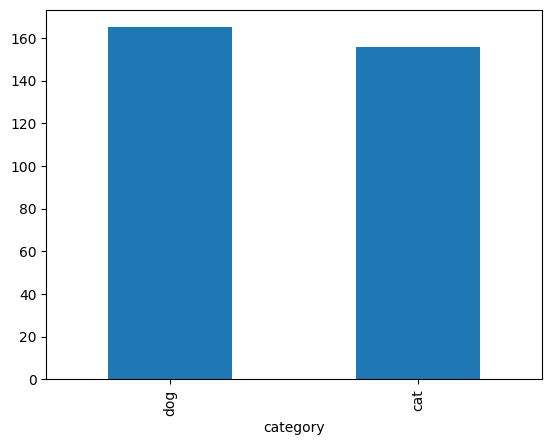

In [18]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

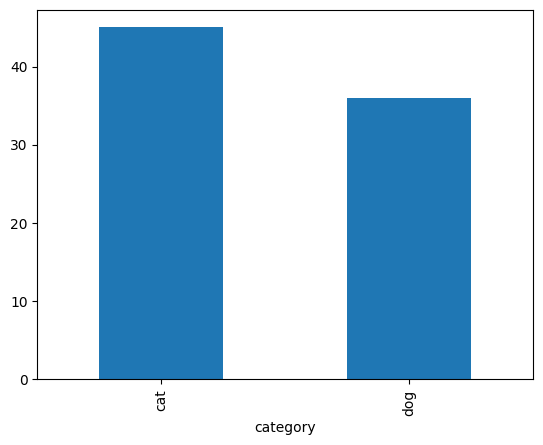

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
validate_df.shape

(81, 2)

In [21]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32 #  2,4,8,16,32,64,128,256

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size

)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 321 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [32]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 81 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [33]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


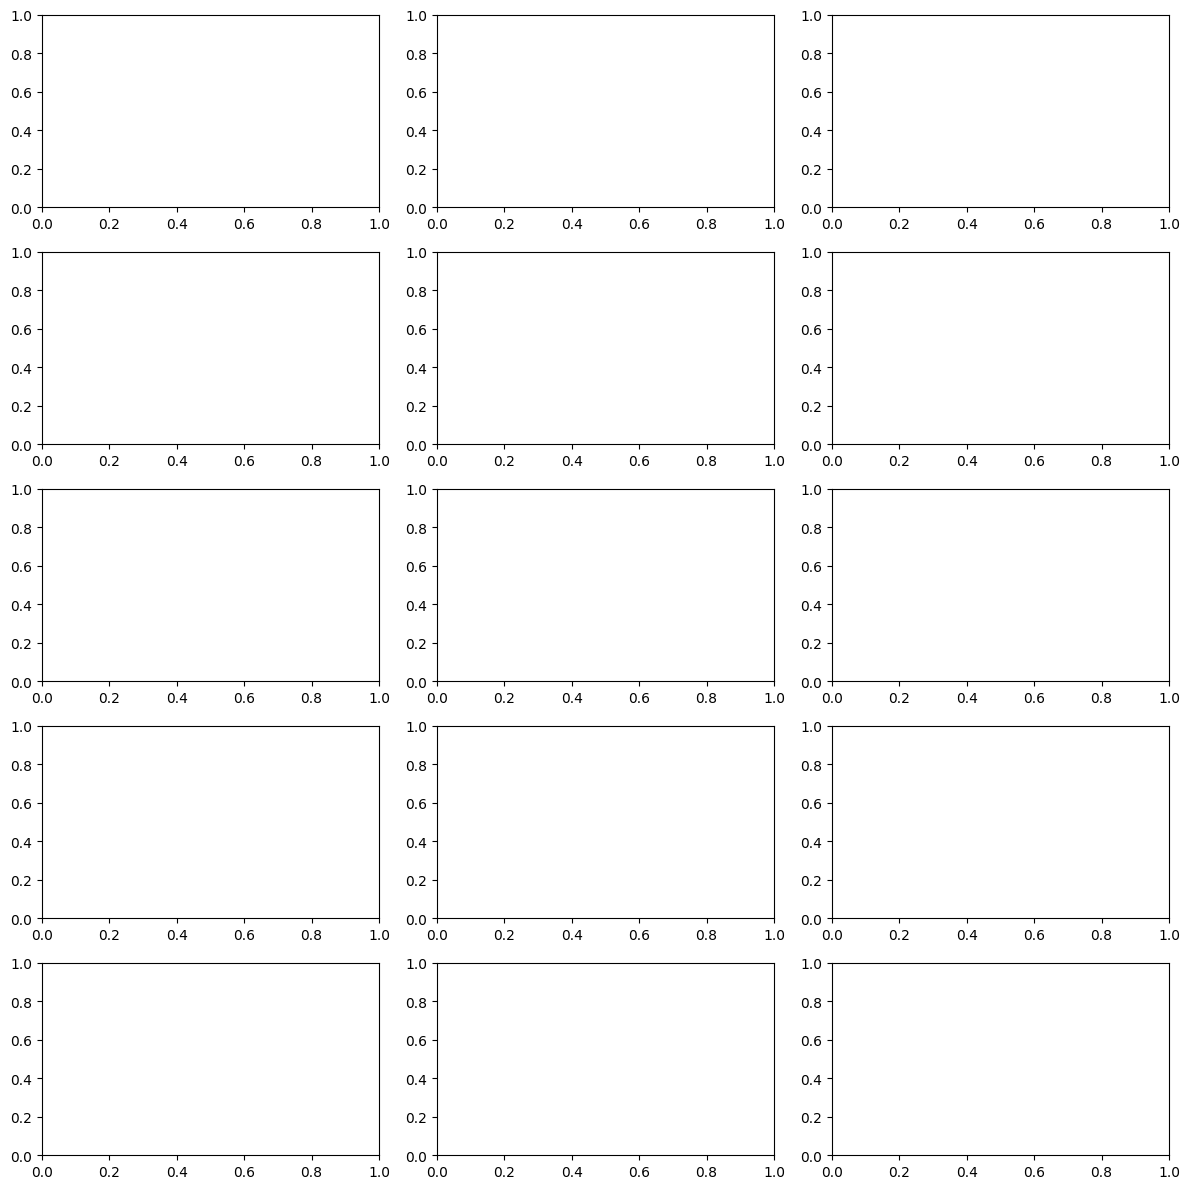

In [56]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()





In [ ]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

model.save("model.h5")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
from google.colab.patches import cv2_imshow

for i in range(10):
    all_test_images = os.listdir('/content/drive/MyDrive/test')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'/content/drive/MyDrive/test/{random_image}')
    img = cv2.resize(img, (128, 128))

    org = img.copy()
    img = img.reshape(1, 128, 128, 3)

    pred = model.predict(img)

    org = cv2.resize(org, None, fx=3, fy=3)
    cv2_imshow(org)


In [ ]:
from tensorflow.keras.models import load_model
import cv2
import gradio as gr

In [ ]:
def predict(image):
    img = cv2.resize(image,(128,128))
    img = img.reshape(1,128,128,3)
    preds = model.predict(img)[0]
    result = dict()
    result["Cat"] = round(float(list(preds)[0]), 3)
    result["Dog"] = round(float(list(preds)[1]), 3)

    return result

In [ ]:
im = gr.Image()
label = gr.Label(num_top_classes=2)

gr.Interface(fn=predict,
             inputs=im,
             outputs=label,
             title="CNN Demo").launch(share=True, debug=True)

In [ ]:
pip install gradio==3.50